In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
import math
import pandas_bokeh
pd.set_option('display.max_columns',None)
warnings.simplefilter("ignore")
sns.set_style("darkgrid")

In [7]:
#Reading files
gamesByPlayer = pd.read_csv("PlayersDB.csv", index_col=0)
games = pd.read_csv("GamesDB.csv", index_col=0)
teams = pd.read_csv("TeamsDB.csv", index_col=0)
personalData = pd.read_csv("PlayersCommonDB.csv", index_col=0)
player_shooting_df = pd.read_csv("shots_type_stats.csv",index_col=0, header=[0,1])
shot_dist = pd.read_csv("shot_loc.csv",index_col=0)
campa_by_period = pd.read_csv("campa_by_period.csv", index_col=0)

In [8]:
#Preprocess
personalData.BIRTHDATE = pd.to_datetime(personalData.BIRTHDATE)
gamesByPlayer.WL = gamesByPlayer.WL.map({"L":0,"W":1})
gamesByPlayer.sort_values(by="GAME_DATE",inplace=True)
personalData["AGE"] = (pd.Timestamp.today() - personalData.BIRTHDATE) / np.timedelta64(1, 'Y')
personalData["AGE"] = personalData["AGE"].apply(lambda x: math.floor(x))
personalData["HEIGHT"] = personalData["HEIGHT"].apply(lambda x: float(".".join(x.split("-"))))

In [9]:
#We merge personal players data with gamesByPlayer
gamesByPlayer = gamesByPlayer.merge(personalData[["PERSON_ID","HEIGHT","AGE",\
                                    "POSITION","SEASON_EXP"]], left_on="PLAYER_ID", \
                                    right_on="PERSON_ID", how="left")

In [10]:
#Get dfs with just Denver Nugget's data
den_games = gamesByPlayer[gamesByPlayer["TEAM_ABBREVIATION"]=="DEN"]
den_consolidated = teams[teams["TEAM_ABBREVIATION"]=="DEN"]

In [11]:
#Get dfs with just Facundo Campazzo's data
campa = gamesByPlayer[gamesByPlayer["PLAYER_NAME"]=='Campazzo, Facundo']
campa_consolidated = teams[teams["PLAYER_NAME"]=='Campazzo, Facundo']

In [12]:
campa.sort_values(by="GAME_DATE",inplace=True)

#Get a different df for every one of the 3 stages in Campazzo's season
campa.loc[campa["GAME_DATE"]<"2021-02-16", "Stage"] = "1"
campa.loc[(campa["GAME_DATE"]>="2021-02-16")&(campa["GAME_DATE"]<"2021-05-22"),"Stage"] = "2"
campa.loc[campa["GAME_DATE"]>="2021-05-22","Stage"] = "3"

campa1 = campa[campa["Stage"]=="1"]
campa2 = campa[campa["Stage"]=="2"]
campa3 = campa[campa["Stage"]=="3"]

# Age

In [13]:
x = np.sort(personalData["AGE"])
y = np.arange(1,len(x)+1 ) / len(x)

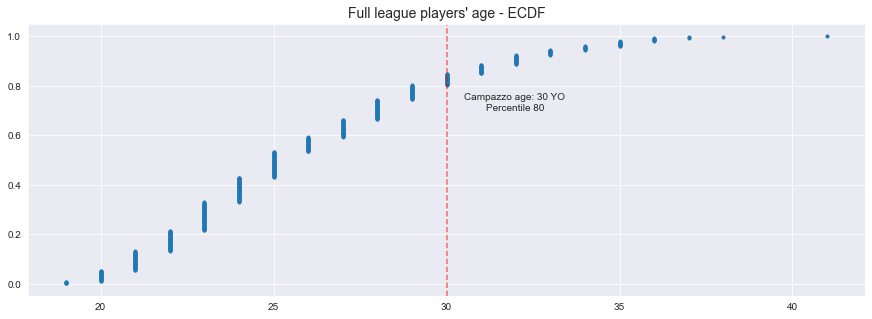

In [14]:
plt.figure(figsize=(15,5))
plt.title("Full league players' age - ECDF", size=14)
plt.plot(x, y,marker=".",linestyle="none")
plt.axvline(x=30, color="red", alpha=0.6, ls="--")
plt.annotate("Campazzo age: 30 YO\n        Percentile 80", xy=(30.5,0.7))
plt.savefig("images\AGE.png", bbox_inches='tight')

In [15]:
np.percentile(gamesByPlayer.AGE,80)

30.0

# Games Played

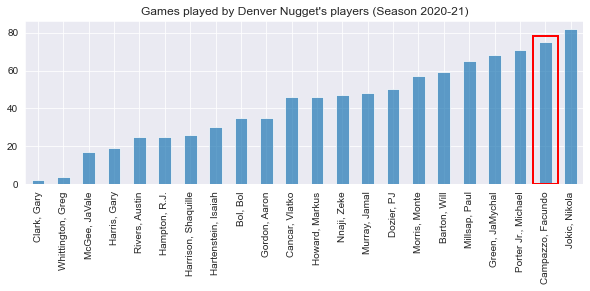

In [16]:
plt.figure(figsize=(10,3))
plt.Rectangle((5,1), 10, 10, fc='blue',ec="red")
den_games.groupby("PLAYER_NAME").size().sort_values().plot.bar(alpha=0.7,\
                                title="Games played by Denver Nugget's players (Season 2020-21)")
rectangle = plt.Rectangle((19.5,0), 1, 78,facecolor='none', edgecolor='red', lw=2)
plt.gca().add_patch(rectangle)
plt.xlabel("");
plt.savefig("images\GamesPLayedDEN.png", bbox_inches='tight')

# Minutes

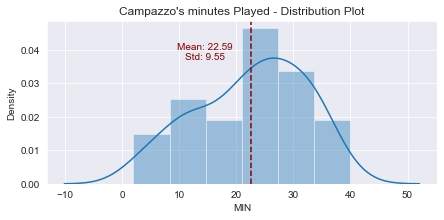

In [17]:
plt.figure(figsize=(7,3))
sns.distplot(campa.MIN)
plt.axvline(campa.MIN.mean(), c="darkred", ls="--")
plt.annotate(f"Mean: {round(campa.MIN.mean(),2)}", xy=(campa.MIN.mean()-13,0.04), c="darkred")
plt.annotate(f"Std: {round(campa.MIN.std(),2)}", xy=(campa.MIN.mean()-11.5,0.037), c="darkred")
plt.title("Campazzo's minutes Played - Distribution Plot")
plt.savefig("images\MIN.png", bbox_inches='tight')

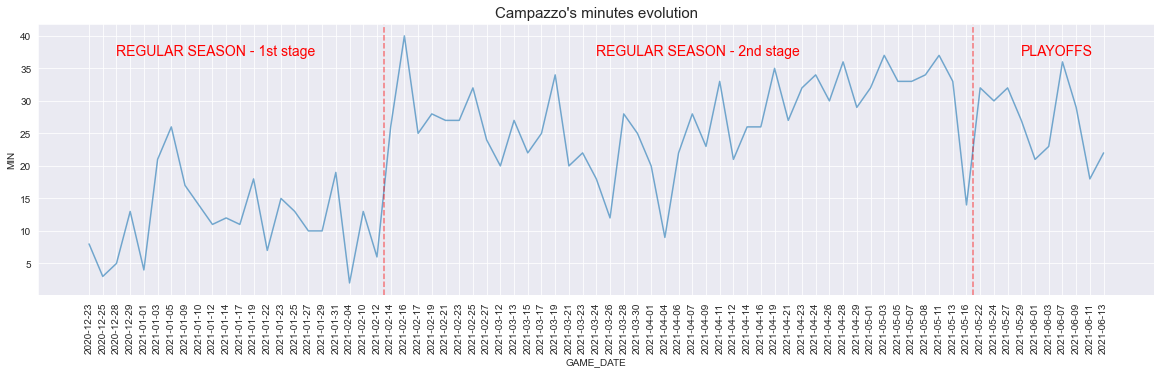

In [18]:
ax = plt.figure(figsize=(20,5))
sns.lineplot(x="GAME_DATE", y="MIN", data=campa, alpha=.6)
plt.axvline(x=64.5, c="red",alpha=0.5, ls="--")
plt.axvline(x=21.5, c="red",alpha=0.5, ls="--")
plt.annotate("REGULAR SEASON - 1st stage",xy=(2,37), c="red", size=14)
plt.annotate("REGULAR SEASON - 2nd stage",xy=(37,37), c="red", size=14)
plt.annotate("PLAYOFFS",xy=(68,37), c="red", size=14)
plt.title("Campazzo's minutes evolution", size=15)
plt.xticks(rotation=90, size=10);
plt.savefig("images\MIN_Season.png", bbox_inches='tight')

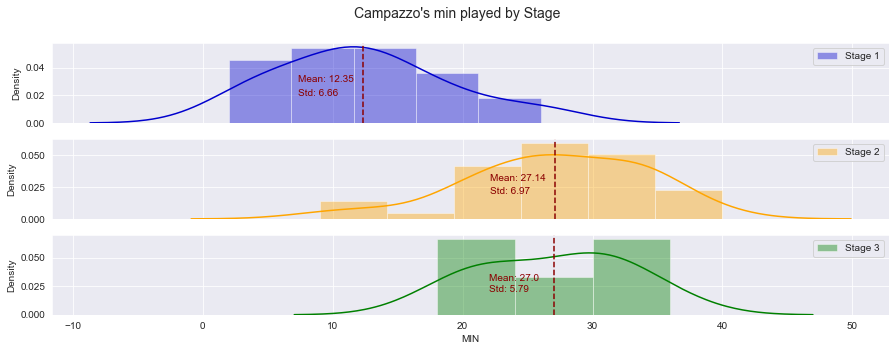

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
fig.suptitle("Campazzo's min played by Stage", size=14)
color=iter(["mediumblue","orange","green"])
for tup in [(campa1,axes[0],"Stage 1"), (campa2,axes[1],"Stage 2"), (campa3,axes[2],"Stage 3")]:
    sns.distplot(tup[0].MIN, ax=tup[1], label=tup[2], color=next(color))
    tup[1].axvline(tup[0].MIN.mean(), c="darkred", ls="--")
    tup[1].annotate(f"Mean: {round(tup[0].MIN.mean(),2)}",\
                    xy=(tup[0].MIN.mean()-5,0.03), c="darkred")
    tup[1].annotate(f"Std: {round(tup[0].MIN.std(),2)}",\
                    xy=(tup[0].MIN.mean()-5,0.02), c="darkred")
    tup[1].legend()
plt.savefig("images\MIN_per_season.png", bbox_inches='tight')

In [20]:
campa_by_period.GROUP_VALUE = campa_by_period.GROUP_VALUE\
                            .map({1:"1st",2:"2nd",3:"3rd",4:"4th",5:"O.T.",6:"2nd O.T."})

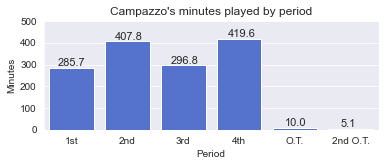

In [21]:
plt.figure(figsize=(6,2))
sns.barplot(campa_by_period.GROUP_VALUE, campa_by_period.MIN, color="royalblue")
plt.xlabel("Period")
plt.ylabel("Minutes")
plt.title("Campazzo's minutes played by period", size=12)
plt.ylim(0,500,10)

i=-.25
for x in campa_by_period.GROUP_VALUE:
    minutes = campa_by_period[campa_by_period["GROUP_VALUE"]==x]["MIN"].values[0]
    plt.annotate(f"{round(minutes,1)}", xy=(i, minutes+8), size=11)
    i = i+1.015
plt.savefig("images\Min_per_period.png", bbox_inches='tight')

# Points

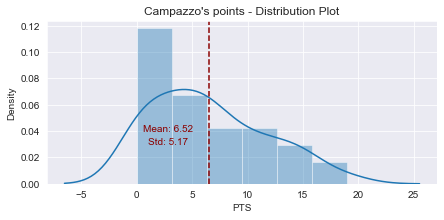

In [22]:
plt.figure(figsize=(7,3))
sns.distplot(campa.PTS)
plt.axvline(campa.PTS.mean(), c="darkred", ls="--")
plt.annotate(f"Mean: {round(campa.PTS.mean(),2)}", xy=(campa.PTS.mean()-6,0.04), c="darkred")
plt.annotate(f"Std: {round(campa.PTS.std(),2)}", xy=(campa.PTS.mean()-5.5,0.030), c="darkred")
plt.title("Campazzo's points - Distribution Plot")
plt.savefig("images\PTS.png", bbox_inches='tight')

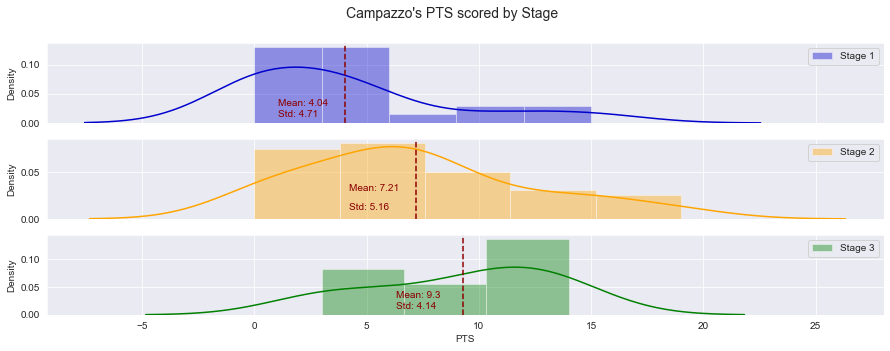

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
fig.suptitle("Campazzo's PTS scored by Stage", size=14)
variable = "PTS"
color=iter(["mediumblue","orange","green"])
for tup in [(campa1,axes[0],"Stage 1"), (campa2,axes[1],"Stage 2"), (campa3,axes[2],"Stage 3")]:
    sns.distplot(tup[0][variable], ax=tup[1], label=tup[2], color=next(color))
    tup[1].axvline(tup[0][variable].mean(), c="darkred", ls="--")
    tup[1].annotate(f"Mean: {round(tup[0][variable].mean(),2)}",\
                    xy=(tup[0][variable].mean()-3,0.03), c="darkred")
    tup[1].annotate(f"Std: {round(tup[0][variable].std(),2)}",\
                    xy=(tup[0][variable].mean()-3,0.01), c="darkred")
    tup[1].legend()
plt.savefig("images\PTS_per_season.png", bbox_inches='tight')

# Points & Minutes

In [24]:
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [25]:
campa.plot_bokeh(kind="scatter",
             x="MIN",
             y=["PTS"],
             category="Stage",
             xlabel="MIN",
             ylabel="PTS", title=" | PTS vs MIN - Scatterplot")

Figure(id='1003', ...)

In [84]:
campa1[campa1["PTS"]<15].PTS.mean()

3.0

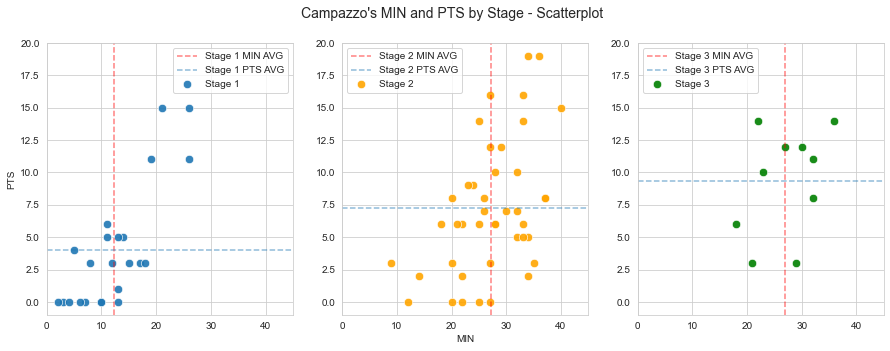

In [26]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1,3, figsize=(15, 5))
fig.suptitle("Campazzo's MIN and PTS by Stage - Scatterplot", size=14)

sns.scatterplot(x=campa1.MIN, y=campa1.PTS, label="Stage 1", alpha=.9, ax=axes[0], s=70)
axes[0].axvline(x=campa1.MIN.mean(), color="red", alpha=.5,ls="--", label="Stage 1 MIN AVG")
axes[0].axhline(y=campa1.PTS.mean(), alpha=.5, ls="--", label="Stage 1 PTS AVG")
axes[0].set_xlim(0,45)
axes[0].set_ylim(-1,20)
axes[0].set_xlabel("")
axes[0].legend()

sns.scatterplot(x=campa2.MIN, y=campa2.PTS, label="Stage 2", alpha=.9, ax=axes[1], color="orange", s=70)
axes[1].axvline(x=campa2.MIN.mean(), color="red", alpha=.5,ls="--", label="Stage 2 MIN AVG")
axes[1].axhline(y=campa2.PTS.mean(), alpha=.5, ls="--", label="Stage 2 PTS AVG")
axes[1].set_xlim(0,45)
axes[1].set_ylim(-1,20)
axes[1].set_ylabel("")
axes[1].legend()

sns.scatterplot(x=campa3.MIN, y=campa3.PTS, label="Stage 3", alpha=.9, ax=axes[2], color="green", s=70)
axes[2].axvline(x=campa3.MIN.mean(), color="red", alpha=.5,ls="--", label="Stage 3 MIN AVG")
axes[2].axhline(y=campa3.PTS.mean(), alpha=.5, ls="--", label="Stage 3 PTS AVG")
axes[2].set_xlim(0,45)
axes[2].set_ylim(-1,20)
axes[2].set_ylabel("")
axes[2].set_xlabel("")
axes[2].legend()

plt.savefig("images\MIN_PTS_Season.png", bbox_inches='tight')

# Shots

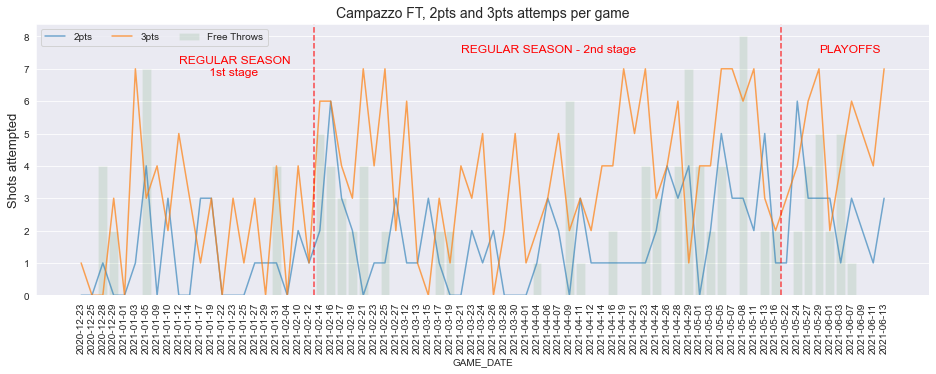

In [27]:
ax = plt.figure(figsize=(16,5))
sns.set_style("darkgrid")
sns.barplot(x="GAME_DATE", y="FTA", data=campa, label="Free Throws", alpha=.1, color="green")
sns.lineplot(x="GAME_DATE", y="FG2A", data=campa, label="2pts", alpha=.6)
sns.lineplot(x="GAME_DATE", y="FG3A", data=campa, label="3pts", alpha=.7)

plt.axvline(x=64.5, c="red",alpha=0.7, ls="--")
plt.axvline(x=21.5, c="red",alpha=0.7, ls="--")
plt.annotate("REGULAR SEASON\n         1st stage",xy=(9,6.8), c="red", size=12)
plt.annotate("REGULAR SEASON - 2nd stage",xy=(35,7.5), c="red", size=12)
plt.annotate("PLAYOFFS",xy=(68,7.5), c="red", size=12)
plt.title("Campazzo FT, 2pts and 3pts attemps per game", size=14)
plt.ylabel("Shots attempted", size="13")
plt.xticks(rotation=90);
plt.legend(fontsize=11)
plt.legend(ncol=3)
plt.savefig("images\Shots_Season.png", bbox_inches='tight')

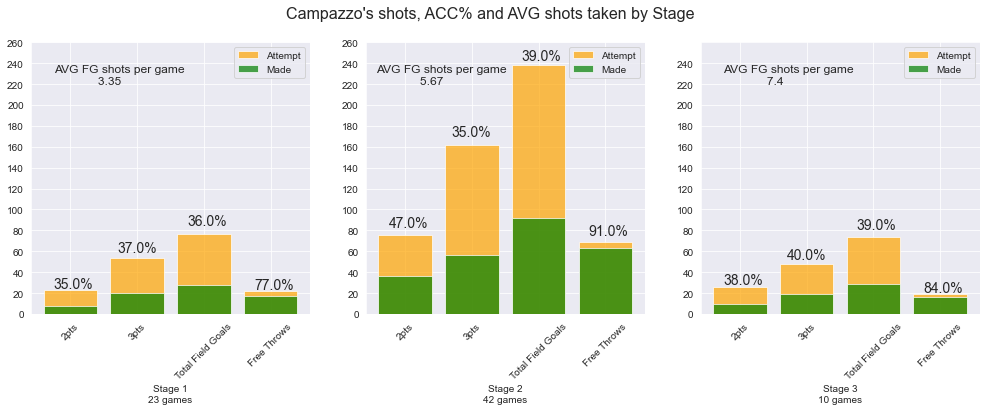

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle("Campazzo's shots, ACC% and AVG shots taken by Stage", size=16)
meanshots    = []
meanshots.append(round(campa1.FGA.sum()/campa1.shape[0],2))
meanshots.append(round(campa2.FGA.sum()/campa2.shape[0],2))
meanshots.append(round(campa3.FGA.sum()/campa3.shape[0],2))

#Season 1
frame = campa1
i = 0
axes[i].bar(x="2pts",\
        height=frame.FG2A.sum(), alpha=0.7, color="orange", label="Attempt")
axes[i].bar(x="2pts",\
        height=frame.FG2M.sum(), alpha=0.7, color="green", label="Made")
axes[i].bar(x="3pts",\
        height=frame.FG3A.sum(), alpha=0.7, color="orange")
axes[i].bar(x="3pts",\
        height=frame.FG3M.sum(), alpha=0.7, color="green")
axes[i].bar(x="Total Field Goals",\
        height=frame.FGA.sum(), color="orange", alpha=0.7)
axes[i].bar(x="Total Field Goals",\
        height=frame.FGM.sum(), color="green", alpha=0.7)
axes[i].bar(x="Free Throws",
        height=frame.FTA.sum(), color="orange", alpha=0.7)
axes[i].bar(x="Free Throws",\
        height=frame.FTM.sum(), color="green", alpha=0.7)
axes[i].annotate(f"AVG FG shots per game\n             {meanshots[i]}", \
                 xy=(-0.25,220), size=12)
axes[i].annotate(f"{round(frame['FG2M'].sum() / frame['FG2A'].sum(),2)*100}%", \
                 xy=(-0.25,frame['FG2A'].sum()*1.1), size=14)
axes[i].annotate(f"{round(frame['FG3M'].sum() / frame['FG3A'].sum(),2)*100}%", \
                 xy=(0.7,frame['FG3A'].sum()*1.1), size=14)
axes[i].annotate(f"{round(frame['FGM'].sum() / frame['FGA'].sum(),2)*100}%", \
                 xy=(1.75,frame['FGA'].sum()*1.1), size=14)
axes[i].annotate(f"{round(frame['FTM'].sum()/frame['FTA'].sum(),2)*100}%"\
                 , xy=(2.75,frame['FTA'].sum()*1.1), size=14)
axes[i].legend()
axes[i].set_xlabel("Stage 1\n23 games")
axes[i].set_yticks(range(0,270,20))
plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

#Season 2
frame = campa2
i = 1
axes[i].bar(x="2pts",\
        height=frame.FG2A.sum(), alpha=0.7, color="orange", label="Attempt")
axes[i].bar(x="2pts",\
        height=frame.FG2M.sum(), alpha=0.7, color="green", label="Made")
axes[i].bar(x="3pts",\
        height=frame.FG3A.sum(), alpha=0.7, color="orange")
axes[i].bar(x="3pts",\
        height=frame.FG3M.sum(), alpha=0.7, color="green")
axes[i].bar(x="Total Field Goals",\
        height=frame.FGA.sum(), color="orange", alpha=0.7)
axes[i].bar(x="Total Field Goals",\
        height=frame.FGM.sum(), color="green", alpha=0.7)
axes[i].bar(x="Free Throws",
        height=frame.FTA.sum(), color="orange", alpha=0.7)
axes[i].bar(x="Free Throws",\
        height=frame.FTM.sum(), color="green", alpha=0.7)
axes[i].annotate(f"AVG FG shots per game\n             {meanshots[i]}", \
                 xy=(-0.44,220), size=12)
axes[i].annotate(f"{round(frame['FG2M'].sum() / frame['FG2A'].sum(),2)*100}%", \
                 xy=(-0.25,frame['FG2A'].sum()*1.1), size=14)
axes[i].annotate(f"{round(frame['FG3M'].sum() / frame['FG3A'].sum(),2)*100}%", \
                 xy=(0.7,frame['FG3A'].sum()*1.05), size=14)
axes[i].annotate(f"{round(frame['FGM'].sum() / frame['FGA'].sum(),2)*100}%", \
                 xy=(1.75,frame['FGA'].sum()*1.02), size=14)
axes[i].annotate(f"{round(frame['FTM'].sum()/frame['FTA'].sum(),2)*100}%"\
                 , xy=(2.75,frame['FTA'].sum()*1.1), size=14)
axes[i].legend()
axes[i].set_xlabel("Stage 2\n42 games")
axes[i].set_yticks(range(0,270,20))
plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

#Season 3
frame = campa3
i = 2
axes[i].bar(x="2pts",\
        height=frame.FG2A.sum(), alpha=0.7, color="orange", label="Attempt")
axes[i].bar(x="2pts",\
        height=frame.FG2M.sum(), alpha=0.7, color="green", label="Made")
axes[i].bar(x="3pts",\
        height=frame.FG3A.sum(), alpha=0.7, color="orange")
axes[i].bar(x="3pts",\
        height=frame.FG3M.sum(), alpha=0.7, color="green")
axes[i].bar(x="Total Field Goals",\
        height=frame.FGA.sum(), color="orange", alpha=0.7)
axes[i].bar(x="Total Field Goals",\
        height=frame.FGM.sum(), color="green", alpha=0.7)
axes[i].bar(x="Free Throws",
        height=frame.FTA.sum(), color="orange", alpha=0.7)
axes[i].bar(x="Free Throws",\
        height=frame.FTM.sum(), color="green", alpha=0.7)
axes[i].annotate(f"AVG FG shots per game\n             {meanshots[i]}", \
                 xy=(-0.25,220), size=12)
axes[i].annotate(f"{round(frame['FG2M'].sum() / frame['FG2A'].sum(),2)*100}%", \
                 xy=(-0.25,frame['FG2A'].sum()*1.1), size=14)
axes[i].annotate(f"{round(frame['FG3M'].sum() / frame['FG3A'].sum(),2)*100}%", \
                 xy=(0.7,frame['FG3A'].sum()*1.1), size=14)
axes[i].annotate(f"{round(frame['FGM'].sum() / frame['FGA'].sum(),2)*100}%", \
                 xy=(1.75,frame['FGA'].sum()*1.1), size=14)
axes[i].annotate(f"{round(frame['FTM'].sum()/frame['FTA'].sum(),2)*100}%"\
                 , xy=(2.75,frame['FTA'].sum()*1.1), size=14)
axes[i].legend()
axes[i].set_xlabel("Stage 3\n10 games")
axes[i].set_yticks(range(0,260,20))
plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45)

plt.ylim(0,260)
plt.savefig("images\Shots_by_season.png", bbox_inches='tight')

# Height

In [34]:
x = np.sort(personalData["HEIGHT"])
y = np.arange(1,len(x)+1 ) / len(x)

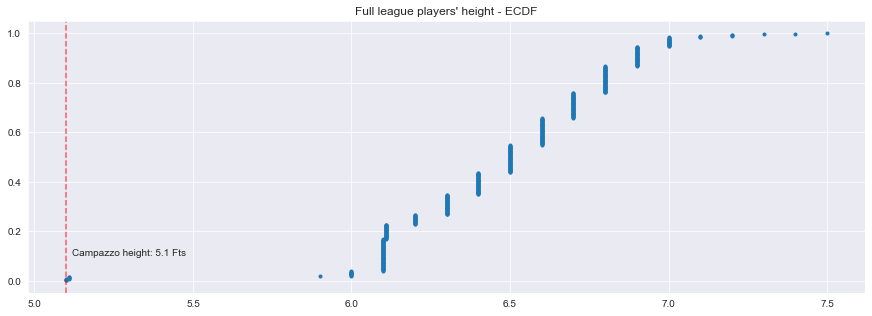

In [35]:
plt.figure(figsize=(15,5))
plt.title("Full league players' height - ECDF", size=12)
plt.plot(x, y,marker=".",linestyle="none")
plt.axvline(x=5.1, color="red", alpha=0.6, ls="--")
plt.annotate("Campazzo height: 5.1 Fts", xy=(5.12,0.1))
plt.savefig("images\height.png", bbox_inches='tight')

In [37]:
np.percentile(personalData["HEIGHT"],1)

5.11

In [38]:
#Only 4 players with 5.1 fts height
personalData[personalData["HEIGHT"]<=5.1].LAST_NAME

29     Campazzo
39       Howard
216      Waters
241      Harper
Name: LAST_NAME, dtype: object

In [39]:
#Get guards & F-Guards dfs with personal data
guard = personalData[personalData["POSITION"]=="Guard"]
Fguard = personalData[personalData["POSITION"].isin(['Guard-Forward','Forward-Guard'])]

In [40]:
x  = np.sort(guard["HEIGHT"])
x1 = np.sort(Fguard["HEIGHT"])
y  = np.arange(1,len(x)+1 ) / len(x)
y2 = np.arange(1,len(x1)+1 ) / len(x1) 

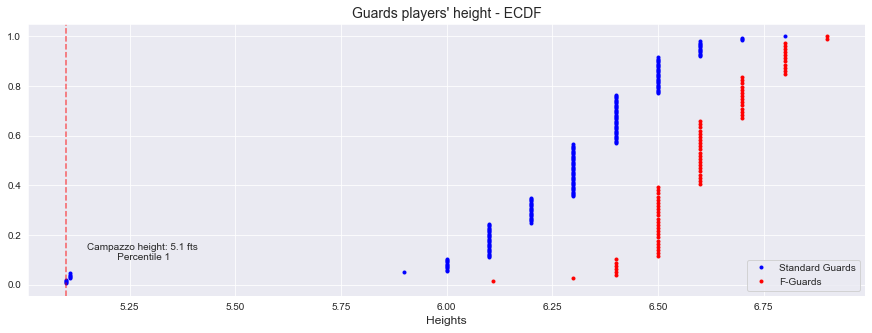

In [41]:
plt.figure(figsize=(15,5))
plt.title("Guards players' height - ECDF", size=14)
plt.plot(x, y,marker=".",linestyle="none", color="blue", label="Standard Guards")
plt.plot(x1, y2,marker=".",linestyle="none",color="red", label="F-Guards")
plt.legend()
plt.axvline(x=5.1, color="red", alpha=0.6, ls="--")
plt.annotate("Campazzo height: 5.1 fts\n           Percentile 1", xy=(5.15,0.1))
plt.xlabel("Heights", size=12)
plt.savefig("images\Height_Guards.png", bbox_inches='tight')

# Shots 2

In [42]:
campazzo_shooting = player_shooting_df[player_shooting_df["player_data"]["PLAYER_NAME"]\
                                                                           .str.contains("Campazzo")]

In [43]:
campazzo_shooting = campazzo_shooting.T.drop("player_data").reset_index()

In [44]:
campazzo_shooting.drop(campazzo_shooting[campazzo_shooting["level_1"].str.contains("PCT")].index, inplace=True)
campazzo_shooting["level_0"] = campazzo_shooting["level_0"].apply(lambda x: x.replace("In The",""))
campazzo_shooting[3] = campazzo_shooting[3].astype("int32")

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
shot_dist["HOME"] = shot_dist["HTM"].map({"DEN":"YES"}).fillna("NO")
shot_dist["PERIOD"] = shot_dist["PERIOD"].map({1:"1st",2:"2nd",3:"3rd",4:"4th"})
shot_dist["EVENT_TYPE_FLAG"] = shot_dist.EVENT_TYPE.map({"Made Shot":1, "Missed Shot":0})

In [47]:
#Clever piece of code from http://savvastjortjoglou.com

from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False, a=1):
    '''
    Draw a basketball court
    '''
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False, alpha=a)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color, alpha=a)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, alpha=a)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, alpha=a)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, alpha=a)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', alpha=a)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, alpha=a)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color, alpha=a)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color, alpha=a)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color, alpha=a)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, alpha=a)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, alpha=a)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False, alpha=a)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [48]:
#By Period

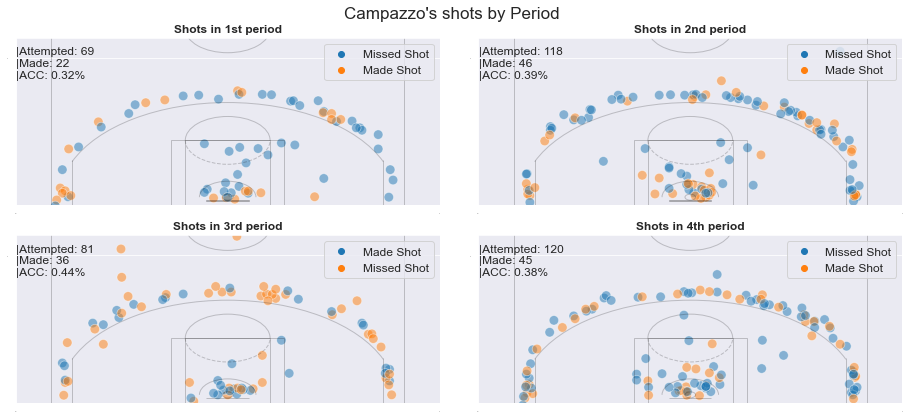

In [49]:
fig, axes = plt.subplots(2,2,figsize=(13,6))
fig.suptitle("Campazzo's shots by Period", size=17)
fig.tight_layout()

j=0
i=0
color=iter(["red","green","orange","blue"])
for x in ["1st","2nd","3rd","4th"]:
    sns.scatterplot(shot_dist[shot_dist["PERIOD"]==x].LOC_X,\
                    shot_dist[shot_dist["PERIOD"]==x].LOC_Y, ax=axes[j][i], s=90,\
                    hue=shot_dist[shot_dist["PERIOD"]==x].EVENT_TYPE,\
                    alpha=.5, color=next(color))
    axes[j][i].set_ylabel("")
    axes[j][i].set_yticks([-50,350]);
    axes[j][i].set_ylim([-20,400]);
    axes[j][i].set_title(f"Shots in {x} period", size=12, fontweight="bold")
    axes[j][i].set_xticks([-300,300]);
    axes[j][i].set_xlabel("")
    axes[j][i].tick_params(labelsize=0)
    draw_court(outer_lines=True, ax=axes[j][i],lw=1, a=.2)
    mean = round(shot_dist[shot_dist["PERIOD"]==x].EVENT_TYPE_FLAG.mean(),2)
    made = shot_dist[shot_dist["PERIOD"]==x].EVENT_TYPE_FLAG.sum()
    attemps = shot_dist[shot_dist["PERIOD"]==x].EVENT_TYPE_FLAG.count()
    axes[j][i].annotate(f"|Attempted: {attemps}\n|Made: {made}\n\
|ACC: {mean}%", xy=(i-300,j+300),fontsize=12)
    axes[j][i].legend(loc="upper right", fontsize=12)
    i=i+1
    if i == 2: 
        j=1
        i=0
        
plt.savefig("images\Shot_chart_by_period.png", bbox_inches='tight')

In [50]:
#By EVENT

In [51]:
missedType = shot_dist[shot_dist["EVENT_TYPE"]=='Missed Shot']\
                            .groupby("ACTION_TYPE").size().sort_values(ascending=False)\
                                .reset_index().rename(columns={0:"Missed"})
madeType = shot_dist[shot_dist["EVENT_TYPE"]=='Made Shot']\
                            .groupby("ACTION_TYPE").size().reset_index()\
                                .rename(columns={0:"Made"})
TypeShots = pd.merge(missedType, madeType, on="ACTION_TYPE", how="left").fillna(0)
TypeShots["%"] = round((TypeShots["Made"] / (TypeShots["Missed"]+TypeShots["Made"]))*100,2)

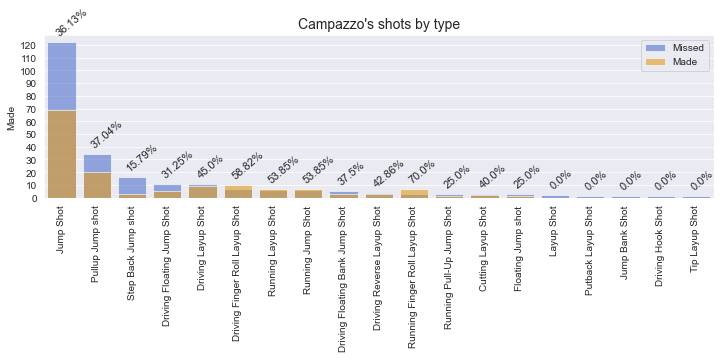

In [52]:
plt.figure(figsize=(12,3))
plt.title("Campazzo's shots by type", size=14)
sns.barplot(TypeShots.ACTION_TYPE, TypeShots.Missed,color="royalblue",\
                                        alpha=0.6, label="Missed")
sns.barplot(TypeShots.ACTION_TYPE, TypeShots.Made, color="orange",\
                                        alpha=0.6, label="Made")
plt.legend(loc="upper right")
plt.xticks(rotation=90)
plt.yticks(range(0,130,10))
plt.xlabel("Shots")
plt.xlabel("")

i=-.2
for x in TypeShots.ACTION_TYPE:
    accuracy = TypeShots[TypeShots["ACTION_TYPE"]==x]["%"].values[0]
    max_column = max(TypeShots[TypeShots["ACTION_TYPE"]==x]["Missed"].values[0],\
                    TypeShots[TypeShots["ACTION_TYPE"]==x]["Made"].values[0])
    plt.annotate(f"{accuracy}%", xy=(i, max_column+5), rotation=40, size=11)
    i = i+1

plt.savefig("images\Type_of_shots.png", bbox_inches='tight')

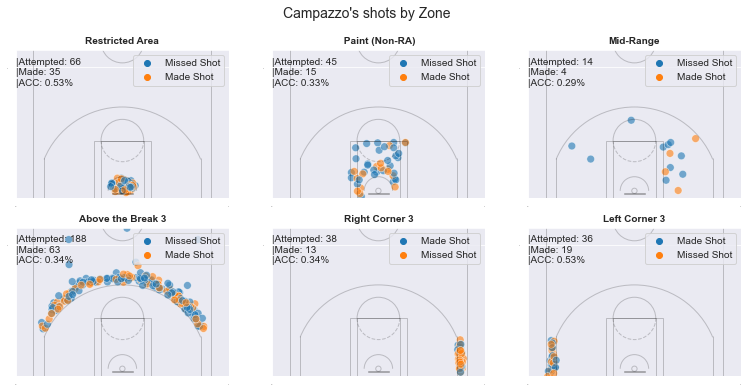

In [53]:
fig, axes = plt.subplots(2,3,figsize=(13,6))
fig.suptitle("Campazzo's shots by Zone", size=14)

i=0
j=0
color=iter(["red","green","orange","blue","black", "darkred"])
for x in ['Restricted Area', 'In The Paint (Non-RA)', 'Mid-Range', \
         'Above the Break 3', 'Right Corner 3', 'Left Corner 3']:
    
    sns.scatterplot(shot_dist[shot_dist["SHOT_ZONE_BASIC"]==x].LOC_X,\
                    shot_dist[shot_dist["SHOT_ZONE_BASIC"]==x].LOC_Y, \
                    hue=shot_dist[shot_dist["SHOT_ZONE_BASIC"]==x].EVENT_TYPE,\
                    ax=axes[j][i], s=60, alpha=.6, color=next(color))
    axes[j][i].set_ylabel("")
    axes[j][i].set_yticks([-50,350]);
    axes[j][i].set_ylim([-20,400]);
    axes[j][i].set_xlabel("", size=10)
    axes[j][i].set_title(f"{x.replace('In The','')}", size=10, weight="bold")
    axes[j][i].set_xticks([-300,300]);
    axes[j][i].tick_params(labelsize=0)
    axes[j][i].legend(loc="upper right")
    mean = round(shot_dist[shot_dist["SHOT_ZONE_BASIC"]==x].EVENT_TYPE_FLAG.mean(),2)
    made = shot_dist[shot_dist["SHOT_ZONE_BASIC"]==x].EVENT_TYPE_FLAG.sum()
    attemps = shot_dist[shot_dist["SHOT_ZONE_BASIC"]==x].EVENT_TYPE_FLAG.count()
    axes[j][i].annotate(f"|Attempted: {attemps}\n|Made: {made}\n\
|ACC: {mean}%", xy=(i-300,j+300))
    draw_court(outer_lines=True, ax=axes[j][i],lw=1, a=.2)
    i=i+1
    if i == 3: 
        j=1
        i=0
plt.savefig("images\Shot_chart_by_zone.png", bbox_inches='tight')

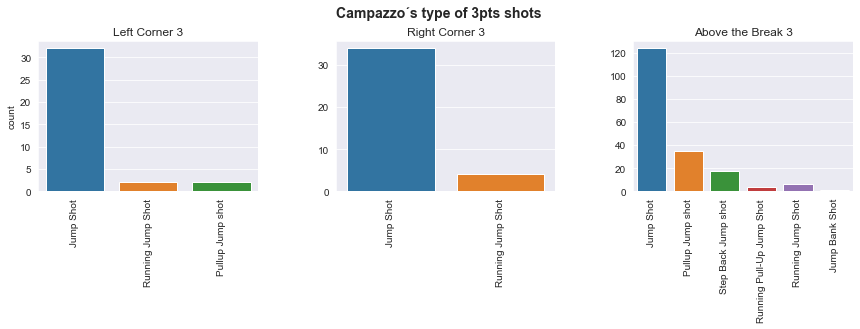

In [55]:
fig, axes = plt.subplots(1,3, figsize=(12,3))
fig.suptitle("Campazzo´s type of 3pts shots", size=14, fontweight="bold")
fig.tight_layout(h_pad=5, w_pad=5)

sns.countplot(shot_dist[shot_dist["SHOT_ZONE_BASIC"]=="Left Corner 3"].ACTION_TYPE,ax=axes[0])
sns.countplot(shot_dist[shot_dist["SHOT_ZONE_BASIC"]=="Right Corner 3"].ACTION_TYPE,ax=axes[1])
sns.countplot(shot_dist[shot_dist["SHOT_ZONE_BASIC"]=="Above the Break 3"].ACTION_TYPE,ax=axes[2])

plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=90)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=90)
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=90)
axes[0].set_title("Left Corner 3");
axes[1].set_title("Right Corner 3");
axes[2].set_title("Above the Break 3");
axes[0].set_xlabel("");
axes[1].set_xlabel("");
axes[2].set_xlabel("");
axes[1].set_ylabel("");
axes[2].set_ylabel("");
plt.savefig("images\Shot_types_3pts.png", bbox_inches='tight')

# Assistances

In [56]:
#Get a df for AST and one for STL from the whole League
ast_df = gamesByPlayer.groupby("PLAYER_NAME").agg({"AST":"mean"}).\
                                                sort_values(by="AST").reset_index()
stl_df = gamesByPlayer.groupby("PLAYER_NAME").agg({"STL":"mean"}).\
                                                sort_values(by="STL").reset_index()

In [57]:
#Get a guards df but with complete games data
guard_df = gamesByPlayer[gamesByPlayer["POSITION"]=="Guard"]
#Get a df for AST and one for STL only from the Guards
guard_ast_df = guard_df.groupby("PLAYER_NAME").agg({"AST":"mean"}).sort_values(by="AST").reset_index()
guard_stl_df = guard_df.groupby("PLAYER_NAME").agg({"STL":"mean"}).sort_values(by="STL").reset_index()

In [59]:
#Get a rookies df 
fresh_df = gamesByPlayer[gamesByPlayer["SEASON_EXP"]==0]
#Get a df for AST and one for STL only from rookies
fresh_df_ast = fresh_df.groupby("PLAYER_NAME").agg({"AST":"mean"}).sort_values(by="AST").reset_index()
fresh_df_stl = fresh_df.groupby("PLAYER_NAME").agg({"STL":"mean"}).sort_values(by="STL").reset_index()

In [60]:
print(f"> League percentile 85th:{round(np.percentile(ast_df.AST,85),2)}\n\
> Guards percentile 74th: {round(np.percentile(guard_ast_df.AST,74),2)}\n\
> Rookies percentile 95th: {round(np.percentile(fresh_df_ast.AST,95),2)}")

> League percentile 85th:3.62
> Guards percentile 74th: 3.63
> Rookies percentile 95th: 3.63


In [61]:
print(f"> Campazzo mean: {round(campa.AST.mean(),2)}\n{'-'*25}\n\
> League mean: {round(ast_df.AST.mean(),2)}\n\
> Gurads mean: {round(guard_df.AST.mean(),2)}\n\
> Rookies mean: {round(fresh_df.AST.mean(),2)}")

> Campazzo mean: 3.64
-------------------------
> League mean: 1.96
> Gurads mean: 3.13
> Rookies mean: 1.51


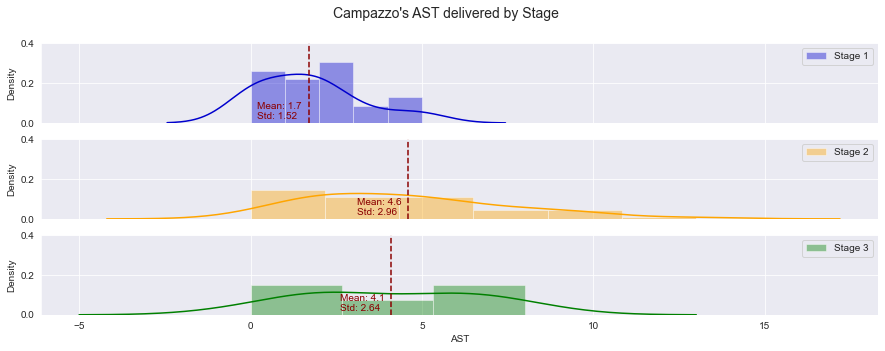

In [62]:
fig, axes = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
fig.suptitle("Campazzo's AST delivered by Stage", size=14)
variable = "AST"
color=iter(["mediumblue","orange","green"])
for tup in [(campa1,axes[0],"Stage 1"), (campa2,axes[1],"Stage 2"), (campa3,axes[2],"Stage 3")]:
    sns.distplot(tup[0][variable], ax=tup[1], label=tup[2], color=next(color))
    tup[1].axvline(tup[0][variable].mean(), c="darkred", ls="--")
    tup[1].annotate(f"Mean: {round(tup[0][variable].mean(),2)}",\
                    xy=(tup[0][variable].mean()-1.5,0.07), c="darkred")
    tup[1].annotate(f"Std: {round(tup[0][variable].std(),2)}",\
                    xy=(tup[0][variable].mean()-1.5,0.02), c="darkred")
    tup[1].legend()
    tup[1].set_ylim(0,0.4)
plt.savefig("images\AST_per_season.png", bbox_inches='tight')

In [63]:
print(f"> League percentile 88th:{round(np.percentile(ast_df.AST,88),2)}\n\
> Guards percentile 78th: {round(np.percentile(guard_ast_df.AST,78),2)}\n\
> Rookies percentile 97th: {round(np.percentile(fresh_df_ast.AST,97),2)}")

> League percentile 88th:4.34
> Guards percentile 78th: 4.26
> Rookies percentile 97th: 4.34


# STD

In [64]:
print(f"> League percentile 94th:{round(np.percentile(stl_df.STL,94),2)}\n\
> Guards percentile 89th: {round(np.percentile(guard_stl_df.STL,89),2)}\n\
> Rookies percentile 98th: {round(np.percentile(fresh_df_stl.STL,98),2)}")

> League percentile 94th:1.25
> Guards percentile 89th: 1.24
> Rookies percentile 98th: 1.25


In [65]:
print(f"> Campazzo mean: {round(campa.STL.mean(),2)}\n{'-'*25}\n\
> League mean: {round(stl_df.STL.mean(),2)}\n\
> Gurads mean: {round(guard_stl_df.STL.mean(),2)}\n\
> Rookies mean: {round(fresh_df_stl.STL.mean(),2)}")

> Campazzo mean: 1.24
-------------------------
> League mean: 0.61
> Gurads mean: 0.68
> Rookies mean: 0.43


# REBOUNDS

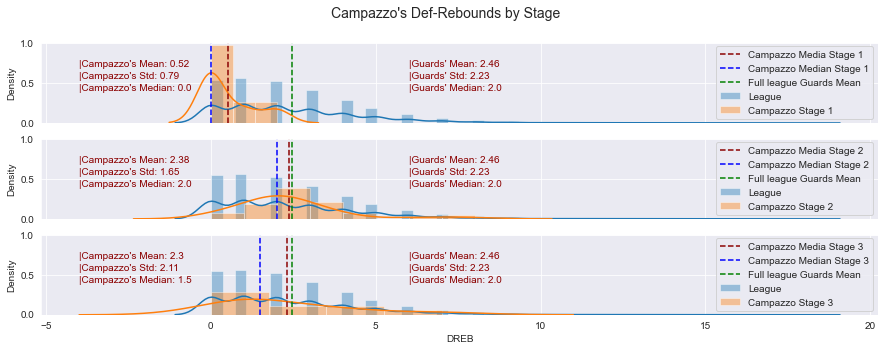

In [66]:
fig, axes = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
fig.suptitle("Campazzo's Def-Rebounds by Stage", size=14)
feature = "DREB"
for tup in [(campa1,axes[0],"Stage 1"), (campa2,axes[1],"Stage 2"), (campa3,axes[2],"Stage 3")]:
    sns.distplot(guard_df[feature], ax=tup[1], label="League")
    sns.distplot(tup[0][feature], ax=tup[1], label=f"Campazzo {tup[2]}")
    
    tup[1].axvline(tup[0][feature].mean(), c="darkred", ls="--", label=f"Campazzo Media {tup[2]}")
    tup[1].axvline(tup[0][feature].median(), c="blue", ls="--", label=f"Campazzo Median {tup[2]}")
    tup[1].axvline(guard_df[feature].mean(), c="green", ls="--", label="Full league Guards Mean")
    
    tup[1].annotate(f"|Campazzo's Mean: {round(tup[0][feature].mean(),2)}",\
                    xy=(-4,0.7), c="darkred")
    tup[1].annotate(f"|Campazzo's Std: {round(tup[0][feature].std(),2)}",\
                    xy=(-4,0.55), c="darkred")
    tup[1].annotate(f"|Campazzo's Median: {round(tup[0][feature].median(),2)}",\
                    xy=(-4,0.40), c="darkred")
    
    tup[1].annotate(f"|Guards' Mean: {round(guard_df[feature].mean(),2)}",\
                    xy=(6,0.7), c="darkred")
    tup[1].annotate(f"|Guards' Std: {round(guard_df[feature].std(),2)}",\
                    xy=(6,0.55), c="darkred")
    tup[1].annotate(f"|Guards' Median: {round(guard_df[feature].median(),2)}",\
                    xy=(6,0.40), c="darkred")
    tup[1].legend(loc="center right")
    tup[1].set_ylim(0,1)
    
plt.savefig(f"images\DREB_per_season.png", bbox_inches='tight')

# WINNING PERCENTAGE

In [67]:
#W_PCT
teams = teams.sort_values(by="W_PCT")

In [68]:
x = np.sort(teams["W_PCT"])
y = np.arange(1,len(x)+1 ) / len(x)

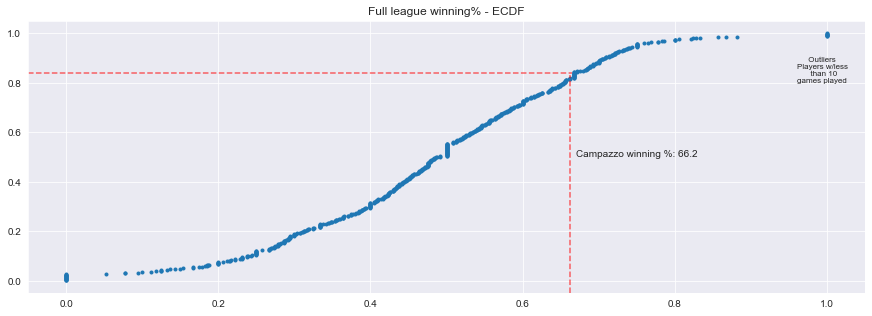

In [69]:
plt.figure(figsize=(15,5))
plt.title("Full league winning% - ECDF")
plt.plot(x, y,marker=".",linestyle="none")
plt.axvline(x=0.662, ymax=0.80, color="red", alpha=0.6, ls="--")
plt.axhline(y=0.84, xmax=0.65, color="red", alpha=0.6, ls="--")
plt.annotate("Campazzo winning %: 66.2", xy=(0.67,0.5))
plt.annotate("     Outliers\nPlayers w/less\n      than 10\ngames played", xy=(0.96,0.8), size=8)
plt.savefig("images\Winning.png", bbox_inches='tight')

In [70]:
print(f"> League Win% percentile 84: {np.percentile(teams['W_PCT'],84)}\n\
> Campazzo Win% mean: {teams[teams['PLAYER_NAME'].str.contains('Campa')].W_PCT.mean()}")

> League Win% percentile 84: 0.667
> Campazzo Win% mean: 0.662
